In [26]:
import os 
import sys 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 

# notebook_dir = "/Users/sergio/Documents/vo/notebooks"
# sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..')))
from utils.dataset import load_dataset
from utils.general_utils import load_config
from utils.camera_utils import Camera
from utils.vo_utils import getProjectionMatrix2

from submodules.MiDaS.midas.model_loader import default_models, load_model
from torchvision import transforms

### load dataset 

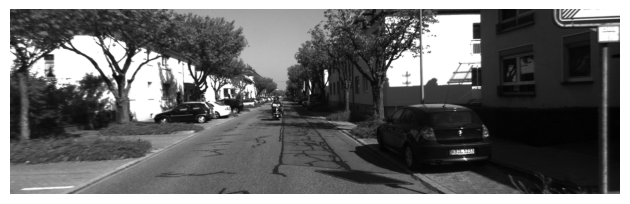

In [20]:
config = load_config("/Users/sergio/Documents/vo/configs/kitti_config.yaml")
dataset = load_dataset(config=config)
dataset.device = "cpu"

image, pose = dataset[0]
plt.imshow(image, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

### cameras

In [32]:
# ---> initiate a camera 
projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)
viewpoint = Camera.init_from_dataset(dataset=dataset, idx=0, projection_matrix=projection_matrix)

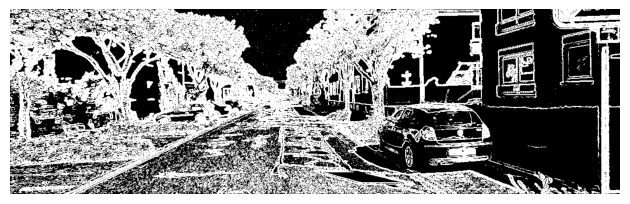

In [33]:
# ---> grad mask 
viewpoint.compute_grad_mask(config=config)
plt.imshow(viewpoint.grad_mask.squeeze(), cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

In [34]:
# ---> load model 
def init_model(model_type="dpt_swin2_tiny_256"):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimize=False
    side=False 
    height=None 
    square=False 
    grayscale=False 
    model_type=model_type
    model_path="submodules/MiDaS/weights/dpt_swin2_tiny_256.pt" 
    model, transform, net_w, net_h = load_model(device=device, model_path=model_path, model_type=model_type, optimize=optimize, height=height, square=square)
    return model

model = init_model() 

Model loaded, number of parameters = 42M


In [47]:
from PIL import Image
import torchvision.transforms.functional as F 

# Convert the original image tensor to a PIL Image
original_image_pil = F.to_pil_image(viewpoint.original_image)

# Define a transform to resize the image and ensure it has 3 channels
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the model's expected input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x)  # Ensure 3 channels
])

# Apply the transform to the original image
resized_image = resize_transform(original_image_pil)

# Add a batch dimension
resized_image = resized_image.unsqueeze(0)

# Perform the prediction
prediction = model.forward(resized_image)

In [48]:
depth = (
    torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=viewpoint.original_image.shape, 
    mode="bicubic", 
    align_corners=False,
    )
).squeeze()

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [256, 256] and output size of torch.Size([1, 376, 1241]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

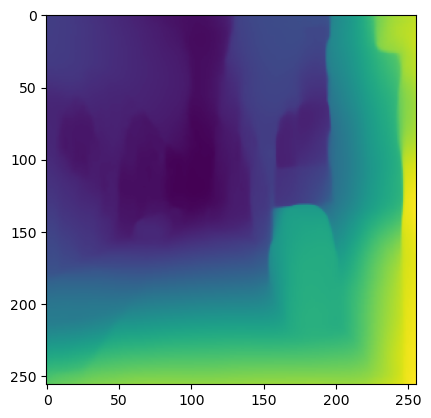

In [43]:
plt.imshow(prediction.detach().squeeze())

In [9]:
# ---> predict a depth map 
viewpoint.model = model
viewpoint.compute_depth()
plt.imshow(viewpoint.depth)
plt.show()

RuntimeError: Given groups=1, weight of size [96, 3, 4, 4], expected input[1, 1, 256, 256] to have 3 channels, but got 1 channels instead